In [16]:
from itertools import product
import pandas as pd
import numpy as np
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('Solarize_Light2')
from scipy.special import comb
from scipy.stats import binom
from sklearn import datasets
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree  import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, _name_estimators
from sklearn.base import clone,BaseEstimator,ClassifierMixin
from sklearn.metrics import roc_curve,auc,roc_auc_score,accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.externals import six

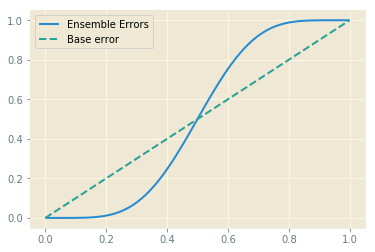

In [2]:
# %%
error_range = np.arange(0.0,1.01,0.01)
n_classifier = 11
np.ceil(n_classifier/2)
ens_errors=binom.sf(n_classifier - np.ceil(n_classifier/2),n_classifier,error_range)
plt.plot(error_range,ens_errors,linewidth=2,label= 'Ensemble Errors')
plt.plot(error_range,error_range,linestyle = '--',label = 'Base error')
plt.legend(loc='upper left')
plt.show()

In [3]:
iris = datasets.load_iris()
X,y = iris.data[50:,[1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.5,random_state = 1,stratify =y)

### Classfying individual 

In [4]:
clf1 = LogisticRegression(penalty='l2',C=0.001,random_state=1,solver='lbfgs')
clf2 = DecisionTreeClassifier(max_depth=1,random_state=1)
clf3 = KNeighborsClassifier(n_neighbors=1)
pipeline1 = Pipeline([['sc1',StandardScaler()],['clf',clf1]])
pipeline3 = Pipeline([['sc2',StandardScaler()],['clf',clf3]])
clf_labels = ['Logistic_Regression','DecisionTree','KNeighborsClassifier']

for label,clf in zip(clf_labels,[pipeline1,clf2,pipeline3]):

    scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring='roc_auc')
    print('ROC Score for [%s] %0.2f +/- %0.2f'% (label,scores.mean(),scores.std()))

ROC Score for [Logistic_Regression] 0.87 +/- 0.17
ROC Score for [DecisionTree] 0.89 +/- 0.16
ROC Score for [KNeighborsClassifier] 0.88 +/- 0.15


In [5]:
class MajorityVoteClassifier_sush(BaseEstimator,ClassifierMixin):
    """
    Paramaters
    ---------------------------
    classifiers: array-like,shape = [n_classifiers]
    vote: str,{'classlabel','probability'}
    defaults to 'classlabel'
    weights: array-like,shape = [n_classifiers]
    classifers are weigthed accordingle
    """
    def __init__(self,classifiers,vote = 'classlabel',weights = None):
        self.classifiers = classifiers
        self.vote = vote
        self.weights = weights
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        return None
    
    def fit(self,X,y):
        self.labelencoders_ = LabelEncoder()
        self.labelencoders_.fit(y)
        self.classes_ = self.labelencoders_.classes_
        y = self.labelencoders_.transform(y)
        self.classifiers_ = []
        for clf in self.classifiers:
            self.classifiers_.append(clone(clf).fit(X,y))
        return self
    def predict(self,X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            _class_array=np.asarray([clf.predict(X) for clf in self.classifiers_])
            _min_classifiers = np.max(_class_array) + 1

            maj_vote=np.argmax(np.apply_along_axis(np.bincount, axis=1, arr= _class_array.T,
                                          minlength =_min_classifiers,weights=self.weights),axis=1)
            maj_vote=self.labelencoders_.inverse_transform(maj_vote)
        return maj_vote
    def predict_proba(self,X):
        _prob_array=np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        average_prob = np.average(_prob_array,axis=0,weights=self.weights)
        return average_prob
    def get_params(self, deep=True):
            """ Get classifier parameter names for GridSearch"""
            if not deep:
                return super(MajorityVoteClassifier_sush, self).get_params(deep=False)
            else:
                out = self.named_classifiers.copy()
                for name, step in (self.named_classifiers.items()):
                    for key, value in (step.get_params(deep=True).items()):
                        out['%s__%s' % (name, key)] = value
                return out

In [6]:
mv_clf=MajorityVoteClassifier_sush(classifiers=[pipeline1,clf2,pipeline3])
clf_labels = ['Logistic_Regression','DecisionTree','KNeighborsClassifier','Maj Voting']
for label,clf in zip(clf_labels,[pipeline1,clf2,pipeline3,mv_clf]):
    scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring='roc_auc')
    print('ROC Score for [%s] %0.2f +/- %0.2f'% (label,scores.mean(),scores.std()))

ROC Score for [Logistic_Regression] 0.87 +/- 0.17
ROC Score for [DecisionTree] 0.89 +/- 0.16
ROC Score for [KNeighborsClassifier] 0.88 +/- 0.15
ROC Score for [Maj Voting] 0.94 +/- 0.13


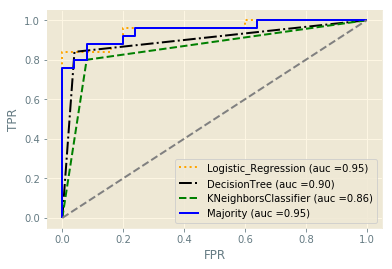

In [7]:
clf1 = LogisticRegression(penalty='l2',C=0.001,random_state=1,solver='lbfgs')
clf2 = DecisionTreeClassifier(max_depth=1,random_state=1)
clf3 = KNeighborsClassifier(n_neighbors=1)
pipeline1 = Pipeline([['sc1',StandardScaler()],['clf',clf1]])
pipeline3 = Pipeline([['sc2',StandardScaler()],['clf',clf3]])
clf_labels = ['Logistic_Regression','DecisionTree','KNeighborsClassifier','Majority']
mv_clf=MajorityVoteClassifier_sush(classifiers=[pipeline1,clf2,pipeline3])
colors = ['orange','black','green','blue']
linestyles = [':','-.','--','-']
lst_classifiers = [pipeline1,clf2,pipeline3,mv_clf]
for clf,lbl,clr,ls in zip(lst_classifiers,clf_labels,colors,linestyles):
    clf.fit(X_train,y_train)
    y_pred = clf.predict_proba(X_test)
    fpr,tpr, thresholds = roc_curve(y_test,y_pred[:,1])
    plt.plot(fpr,tpr,color=clr,linestyle= ls,label= '%s (auc =%0.2f)'%(lbl,roc_auc_score(y_test,y_pred[:,1])))
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],linestyle = '--',color='gray')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

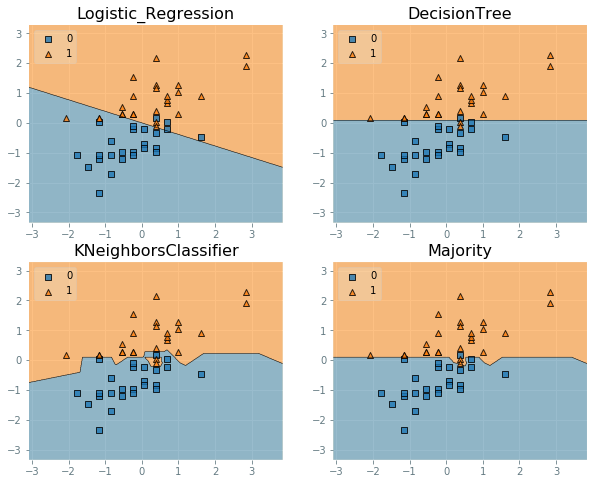

In [8]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
clf1 = LogisticRegression(penalty='l2',C=0.001,random_state=1,solver='lbfgs')
clf2 = DecisionTreeClassifier(max_depth=1,random_state=1)
clf3 = KNeighborsClassifier(n_neighbors=1)
pipeline1 = Pipeline([['sc1',StandardScaler()],['clf',clf1]])
pipeline3 = Pipeline([['sc2',StandardScaler()],['clf',clf3]])
clf_labels = ['Logistic_Regression','DecisionTree','KNeighborsClassifier','Majority']
mv_clf=MajorityVoteClassifier_sush(classifiers=[pipeline1,clf2,pipeline3])
colors = ['orange','black','green','blue']
linestyles = [':','-.','--','-']
lst_classifiers = [pipeline1,clf2,pipeline3,mv_clf]
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10,8))
for clf, lab, grd in zip(lst_classifiers,clf_labels,product([0, 1], repeat=2)):
    clf.fit(X_train_std, y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_train_std, y=y_train, clf=clf, legend=2)
    plt.title(lab)

plt.show()

In [9]:
mv_clf.get_params()

{'pipeline-1': Pipeline(memory=None,
      steps=[('sc1', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=1, solver='lbfgs',
           tol=0.0001, verbose=0, warm_start=False)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=1,
             splitter='best'),
 'pipeline-2': Pipeline(memory=None,
      steps=[('sc2', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=Non

In [10]:
params = {'decisiontreeclassifier__max_depth':[1,2,3],'pipeline-1__clf__C':[0.001,0.1,100]}
grid = GridSearchCV(estimator=mv_clf,param_grid=params,cv=10,scoring='roc_auc',iid=True)
grid.fit(X_train,y_train)
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %s"
          % (grid.cv_results_['mean_test_score'][r], 
             grid.cv_results_['std_test_score'][r] , 
             grid.cv_results_['params'][r]))

0.933 +/- 0.14 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.947 +/- 0.14 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.973 +/- 0.07 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100}
0.947 +/- 0.14 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.947 +/- 0.14 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.973 +/- 0.07 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100}
0.947 +/- 0.14 {'decisiontreeclassifier__max_depth': 3, 'pipeline-1__clf__C': 0.001}
0.947 +/- 0.14 {'decisiontreeclassifier__max_depth': 3, 'pipeline-1__clf__C': 0.1}
0.973 +/- 0.07 {'decisiontreeclassifier__max_depth': 3, 'pipeline-1__clf__C': 100}


In [30]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

# if the Breast Cancer dataset is temporarily unavailable from the
# UCI machine learning repository, un-comment the following line
# of code to load the dataset from a local path:

# df_wine = pd.read_csv('wine.data', header=None)

# drop 1 class
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
            train_test_split(X, y, 
                             test_size=0.2, 
                             random_state=1,
                             stratify=y)

In [32]:
tree = DecisionTreeClassifier(criterion= 'entropy', random_state= 1, max_depth=None)
tree.fit(X_train,y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train,y_train_pred)
tree_test = accuracy_score(y_test,y_test_pred)
print('train accuracy %.2f test accuracy %.2f'%(tree_train,tree_test))

train accuracy 1.00 test accuracy 0.83


In [33]:
sc = StandardScaler()
clf1 = LogisticRegression(penalty='l2',C=100,random_state=1,solver='lbfgs')
pipeline1 = Pipeline([['sc1',StandardScaler()],['clf',clf1]])
pipeline1.fit(X_train,y_train)
y_train_pred = pipeline1.predict(X_train)
y_test_pred = pipeline1.predict(X_test)
pipeline1_train = accuracy_score(y_train,y_train_pred)
pipeline1_test = accuracy_score(y_test,y_test_pred)
print('train accuracy %.2f test accuracy %.2f'%(pipeline1_train,pipeline1_test))

train accuracy 0.89 test accuracy 0.88


In [39]:
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500,
                        bootstrap=True,bootstrap_features=False,
                        n_jobs=1,random_state=1)
bag.fit(X_train,y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train,y_train_pred)
bag_test = accuracy_score(y_test,y_test_pred)
print('train accuracy %.2f test accuracy %.2f'%(bag_train,bag_test))

train accuracy 1.00 test accuracy 0.92


In [42]:
bag = BaggingClassifier(base_estimator=pipeline1,
                        n_estimators=500,
                        bootstrap=True,bootstrap_features=False,
                        n_jobs=1,random_state=1)
bag.fit(X_train,y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train,y_train_pred)
bag_test = accuracy_score(y_test,y_test_pred)
print('train accuracy %.2f test accuracy %.2f'%(bag_train,bag_test))

train accuracy 0.91 test accuracy 0.88


In [44]:
mv_clf=MajorityVoteClassifier_sush(classifiers=[pipeline1,clf2,pipeline3])
bag = BaggingClassifier(base_estimator=mv_clf,
                        n_estimators=500,
                        bootstrap=True,bootstrap_features=False,
                        n_jobs=1,random_state=1)
bag.fit(X_train,y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train,y_train_pred)
bag_test = accuracy_score(y_test,y_test_pred)
print('train accuracy %.2f test accuracy %.2f'%(bag_train,bag_test))

train accuracy 0.95 test accuracy 0.92
